# In the Name of God
## Deep Learning HW2 - Problem 2
## Sayed Pouria fatemi 400206324


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn
from torch.utils.data import Dataset , DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part (a)

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Data/HW2_data/international_matches.csv")
df.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


## Part (b)

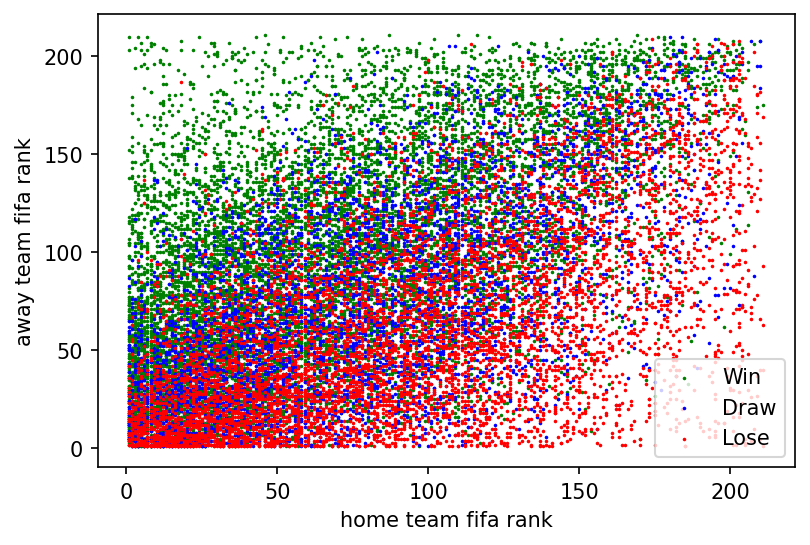

In [ ]:
plt.figure(dpi=150)
plt.scatter(df[df['home_team_result'] == 'Win']['home_team_fifa_rank'], df[df['home_team_result'] == 'Win']['away_team_fifa_rank'], c='g', label='Win', s=0.5)
plt.scatter(df[df['home_team_result'] == 'Draw']['home_team_fifa_rank'], df[df['home_team_result'] == 'Draw']['away_team_fifa_rank'], c='b', label='Draw', s=0.5)
plt.scatter(df[df['home_team_result'] == 'Lose']['home_team_fifa_rank'], df[df['home_team_result'] == 'Lose']['away_team_fifa_rank'], c='r', label='Lose', s=0.5)
plt.legend()
plt.xlabel('home team fifa rank')
plt.ylabel('away team fifa rank')
plt.show()

## Part (c)

In [ ]:
df_clean = df[(df['away_team_total_fifa_points'] != 0) & (df['home_team_total_fifa_points'] != 0)]
df_clean = df_clean[["home_team_fifa_rank", "away_team_fifa_rank", "home_team_total_fifa_points", "away_team_total_fifa_points", "home_team_result"]]
df_clean = df_clean.sample(frac=1)
df_clean.loc[df_clean['home_team_result'] == 'Win', 'home_team_result'] = 2
df_clean.loc[df_clean['home_team_result'] == 'Draw', 'home_team_result'] = 1
df_clean.loc[df_clean['home_team_result'] == 'Lose', 'home_team_result'] = 0
train_df = df_clean[: int(0.75 * len(df_clean))]
test_df = df_clean[int(0.75 * len(df_clean)):]

## Part (d)

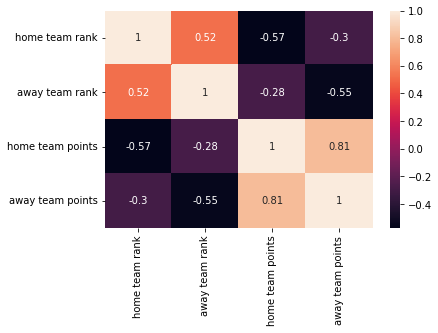

In [ ]:
seaborn.heatmap(df_clean[["home_team_fifa_rank", "away_team_fifa_rank", "home_team_total_fifa_points", "away_team_total_fifa_points"]].corr(),
                annot=True, xticklabels = ["home team rank", "away team rank", "home team points", "away team points"],
                yticklabels = ["home team rank", "away team rank", "home team points", "away team points"])
plt.show()

## Part (e)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_transform=None):
        self.data = dataframe[["home_team_fifa_rank", "away_team_fifa_rank", "home_team_total_fifa_points", "away_team_total_fifa_points"]]
        self.labels = dataframe["home_team_result"]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        X = torch.tensor(self.data.iloc[idx]).to(device).float()
        Y = torch.tensor(self.labels.iloc[idx]).to(device)
        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            Y = self.target_transform(Y)
        return X, Y

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
        )
    def forward(self, x):
        return self.linear_relu_stack(x)

## Part (f)

In [ ]:
class nn_optimizer():
  def __init__(self, model, train_df, test_df, epochs, batch_size, learning_rate):
    self.model = model
    self.epochs = epochs
    self.loss_fn = nn.CrossEntropyLoss()
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
    training_data = CustomDataset(train_df)
    test_data = CustomDataset(test_df)
    self.train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    self.test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

  def train_loop(self):
    size = len(self.train_dataloader.dataset)
    for batch, (X, y) in enumerate(self.train_dataloader):
      pred = self.model(X)
      loss = self.loss_fn(pred, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  def evaluate(self, dataloader, name):
    self.model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
      for X, y in dataloader:
        pred = self.model(X)
        loss += self.loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    print(f"{name} Accuracy: {(100*correct):>0.1f}%, Avg {name} loss: {loss:>8f}")

  def fit(self):
    self.model.train()
    for t in range(self.epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      self.train_loop()
      self.evaluate(self.train_dataloader, 'train')
      self.evaluate(self.test_dataloader, 'test')
      print("**************************************************")

In [ ]:
model = NeuralNetwork().to(device)
nn_opt = nn_optimizer(model, train_df, test_df, 20, 16, 1e-3)
nn_opt.fit()

Epoch 1
-------------------------------
loss: 21.674322  [    0/ 7195]
loss: 1.029582  [ 1600/ 7195]
loss: 1.122331  [ 3200/ 7195]
loss: 1.075023  [ 4800/ 7195]
loss: 1.057429  [ 6400/ 7195]
train Accuracy: 54.9%, Avg train loss: 1.088043
test Accuracy: 55.6%, Avg test loss: 1.090899
**************************************************
Epoch 2
-------------------------------
loss: 1.094585  [    0/ 7195]
loss: 1.143754  [ 1600/ 7195]
loss: 1.008591  [ 3200/ 7195]
loss: 1.168646  [ 4800/ 7195]
loss: 1.077346  [ 6400/ 7195]
train Accuracy: 53.3%, Avg train loss: 1.050440
test Accuracy: 54.4%, Avg test loss: 1.048314
**************************************************
Epoch 3
-------------------------------
loss: 1.074146  [    0/ 7195]
loss: 0.906598  [ 1600/ 7195]
loss: 1.082677  [ 3200/ 7195]
loss: 1.224638  [ 4800/ 7195]
loss: 0.956372  [ 6400/ 7195]
train Accuracy: 56.5%, Avg train loss: 1.010381
test Accuracy: 57.4%, Avg test loss: 1.007201
*********************************************

## Part (g)

In [ ]:
england_ranking = 5
wales_ranking = 19
usa_ranking = 16
iran_ranking = 20
england_tpts = 1728.47
wales_tpts = 1569.82
usa_tpts = 1627.48
iran_tpts = 1564.61

result_dic = {0:'loses', 1:'draws', 2:'wins'} 
teams_list=['England', 'Wales', 'USA']
matches = torch.tensor([[iran_ranking, england_ranking, iran_tpts, england_tpts],
    [iran_ranking, wales_ranking, iran_tpts, wales_tpts],
    [iran_ranking, usa_ranking, iran_tpts, usa_tpts],
    [england_ranking, iran_ranking, england_tpts, iran_tpts],
    [wales_ranking, iran_ranking, wales_tpts, iran_tpts],
    [usa_ranking, iran_ranking, usa_tpts, iran_tpts]]).to(device).float()

results = model(matches).argmax(1)
for i in range(3):
  print(f"Iran (home) {result_dic[results[i].item()]} vs {teams_list[i]} (away).")
for i in range(3,6):
  print(f"{teams_list[i - 3]} (home) {result_dic[results[i].item()]} vs Iran (away).")


Iran (home) loses vs England (away).
Iran (home) wins vs Wales (away).
Iran (home) wins vs USA (away).
England (home) wins vs Iran (away).
Wales (home) wins vs Iran (away).
USA (home) wins vs Iran (away).
